In [1]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from skimage.transform import pyramid_reduce, resize

from sklearn.model_selection import train_test_split  
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import  preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

2.8.0


In [2]:
print(tf.__version__)
print(tf.keras.__version__)

2.8.0
2.8.0


In [3]:
data_root='C:/Users/LENOVO/Documents/DS325 HW'
path_positive_cases = os.path.join('C:/Users/LENOVO/Documents/DS325 HW/CT_COVID/')
path_negative_cases = os.path.join('C:/Users/LENOVO/Documents/DS325 HW/CT_NonCOVID/')

In [4]:
path_negative_cases

'C:/Users/LENOVO/Documents/DS325 HW/CT_NonCOVID/'

In [5]:
#glob function to attach all image files present in the respective pathssize
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))
negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

In [6]:
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

In [7]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 397


In [8]:
positive_images_ls[1]

'C:/Users/LENOVO/Documents/DS325 HW/CT_COVID\\2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png'

In [9]:
# code for loop
img_size = 128
positive_data = np.empty((len(positive_images_ls), img_size, img_size, 3), dtype=np.float32)
negative_data = np.empty((len(negative_images_ls), img_size, img_size, 3), dtype=np.float32)
                    
for i in range(len(positive_images_ls)):
    img = cv2.imread(positive_images_ls[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = resize(img, output_shape=(img_size, img_size, 3), preserve_range=True)
    positive_data[i] = img
        
print(len(positive_data))

349


In [10]:
for i in range(len(negative_images_ls)):
    img = cv2.imread(negative_images_ls[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = resize(img, output_shape=(img_size, img_size, 3), preserve_range=True)
    negative_data[i] = img
        
print(len(negative_data))

397


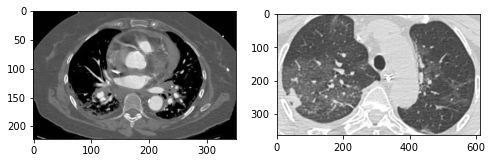

In [11]:
image_positive = cv2.imread(os.path.join(positive_images_ls[2]))
image_negative = cv2.imread(os.path.join(negative_images_ls[2]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [12]:
X = np.concatenate((positive_data, negative_data), axis = 0)
y = [1]*len(positive_data) + [0]*len(negative_data)
print(X.shape)
print(len(y))

(746, 128, 128, 3)
746


In [13]:
X = np.concatenate((positive_data, negative_data), axis = 0)
y = [1]*len(positive_data) + [0]*len(negative_data)
y = np.array(y, dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 8)
class_names = ['covid', 'non_covid']
num_classes = 2
input_shape = (X_train.shape[1],X_train.shape[2])
#normalize the data between 0-1
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype( 'float32') / 255
#Reshape To Match The Keras's Expectations
X_train = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1], 3)
X_test  = X_test.reshape( X_test.shape[0],input_shape[0], input_shape[1], 3)
#one hot encoding
Y_train = tf.keras.utils.to_categorical(y_train, num_classes)
Y_test  = tf.keras.utils.to_categorical(y_test,  num_classes)

In [14]:
epochs   = 10
batch_size = 200

In [15]:
#
tf.random.set_seed(0)                             # set our initial seed

modelA = tf.keras.models.Sequential([             # model type
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid', input_shape=(128,128,3)),#, data_format='channels_first'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),                    # Dropout helps reduce overfitting 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
#===
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, name='SGD')
modelA.compile(optimizer=sgd,
              loss='categorical_crossentropy',    #need to define our loss function
              metrics=['accuracy'])
#===
tstart   = tf.timestamp()
historyA = modelA.fit(X_train, Y_train, verbose=1,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split = 0.2) 
total_time = tf.timestamp() - tstart
print("total time %3.3f seconds"%total_time)

Epoch 1/10
3/3 [==============================] - 8s 2s/step - loss: 1.8551 - accuracy: 0.5189 - val_loss: 0.7050 - val_accuracy: 0.4500
Epoch 2/10
3/3 [==============================] - 5s 1s/step - loss: 0.7002 - accuracy: 0.4685 - val_loss: 0.6958 - val_accuracy: 0.4500
Epoch 3/10
3/3 [==============================] - 5s 1s/step - loss: 0.6941 - accuracy: 0.4601 - val_loss: 0.6880 - val_accuracy: 0.6583
Epoch 4/10
3/3 [==============================] - 5s 1s/step - loss: 0.6815 - accuracy: 0.5483 - val_loss: 0.6791 - val_accuracy: 0.5583
Epoch 5/10
3/3 [==============================] - 4s 1s/step - loss: 0.9062 - accuracy: 0.5189 - val_loss: 0.7042 - val_accuracy: 0.5500
Epoch 6/10
3/3 [==============================] - 4s 1s/step - loss: 0.7164 - accuracy: 0.5315 - val_loss: 0.7029 - val_accuracy: 0.5500
Epoch 7/10
3/3 [==============================] - 4s 1s/step - loss: 0.7094 - accuracy: 0.5315 - val_loss: 0.6863 - val_accuracy: 0.5500
Epoch 8/10
3/3 [=========================

In [16]:
modelA.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dropout (Dropout)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 200)               25401800  
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                        

In [17]:
def printAccuracy(history,results_test):
    print("train loss %.5f \t train acc: %.5f"%(history.history['loss'][-1],history.history['accuracy'][-1]))
    print("valid loss %.5f \t valid acc: %.5f"%(history.history['val_loss'][-1],history.history['val_accuracy'][-1]))
    print("test loss  %.5f \t test acc:  %.5f"%(results_test[0],results_test[1]))
def plot_result(history,results_test):
    # Get training and validation histories
    training_acc = history.history['accuracy']
    val_acc      = history.history['val_accuracy']
    # Create count of the number of epochs
    epoch_count = range(1, len(training_acc) + 1)
    # Visualize loss history
    plt.plot(epoch_count, training_acc, 'b-o',label='Training')
    plt.plot(epoch_count, val_acc, 'r--',label='Validation')
    plt.plot(epoch_count, results_test[1]*np.ones(len(epoch_count)),'k--',label='Test')
    plt.legend()
    plt.title("Training and validation accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

In [18]:
results_test = modelA.evaluate(X_test, Y_test, batch_size=200, verbose=0)    
printAccuracy(historyA,results_test)

train loss 0.70789 	 train acc: 0.49790
valid loss 0.67469 	 valid acc: 0.66667
test loss  0.68571 	 test acc:  0.53333


<function matplotlib.pyplot.show(close=None, block=None)>

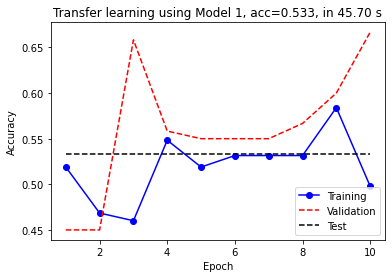

In [19]:
plot_result(historyA,results_test)   
plt.title("Transfer learning using Model 1, acc=%2.3f, in %3.2f s"%(results_test[1],total_time)) #overwrite the title
plt.show

In [20]:
#
tf.random.set_seed(0)                             # set our initial seed

modelB = tf.keras.models.Sequential([             # model type
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
     tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),                    # Dropout helps reduce overfitting 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
#===
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, name='SGD')
modelB.compile(optimizer=sgd,
              loss='categorical_crossentropy',    #need to define our loss function
              metrics=['accuracy'])
#===
tstart   = tf.timestamp()
historyB = modelB.fit(X_train, Y_train, verbose=1,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split = 0.2) 
total_time = tf.timestamp() - tstart
print("total time %3.3f seconds"%total_time)

Epoch 1/10
3/3 [==============================] - 7s 2s/step - loss: 0.6960 - accuracy: 0.5042 - val_loss: 0.6880 - val_accuracy: 0.6750
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 0.6922 - accuracy: 0.5084 - val_loss: 0.6879 - val_accuracy: 0.5500
Epoch 3/10
3/3 [==============================] - 5s 2s/step - loss: 0.6989 - accuracy: 0.4979 - val_loss: 0.6845 - val_accuracy: 0.5500
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 0.6885 - accuracy: 0.5378 - val_loss: 0.6822 - val_accuracy: 0.5500
Epoch 5/10
3/3 [==============================] - 5s 1s/step - loss: 0.6852 - accuracy: 0.5336 - val_loss: 0.6787 - val_accuracy: 0.6083
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 0.6780 - accuracy: 0.6092 - val_loss: 0.6658 - val_accuracy: 0.5500
Epoch 7/10
3/3 [==============================] - 6s 2s/step - loss: 0.7852 - accuracy: 0.4769 - val_loss: 0.7102 - val_accuracy: 0.5500
Epoch 8/10
3/3 [=========================

In [21]:
modelB.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)      

In [22]:
results_test = modelB.evaluate(X_test, Y_test, batch_size=200, verbose=0)    
printAccuracy(historyB,results_test)

train loss 0.69021 	 train acc: 0.53151
valid loss 0.69458 	 valid acc: 0.45000
test loss  0.69375 	 test acc:  0.48000


<function matplotlib.pyplot.show(close=None, block=None)>

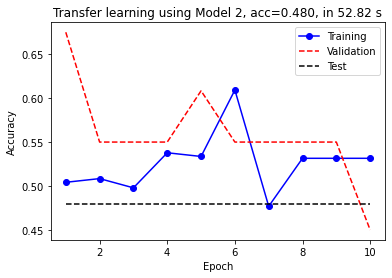

In [23]:
plot_result(historyB,results_test)   
plt.title("Transfer learning using Model 2, acc=%2.3f, in %3.2f s"%(results_test[1],total_time)) #overwrite the title
plt.show

In [24]:
#
tf.random.set_seed(0)                             # set our initial seed

modelC = tf.keras.models.Sequential([             # model type
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
#                            padding='valid'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),                    # Dropout helps reduce overfitting 
    tf.keras.layers.Dense(200, activation='relu'),
#     tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
#===
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, name='SGD')
adm = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
modelC.compile(optimizer=adm,
              loss='categorical_crossentropy',    #need to define our loss function
              metrics=['accuracy'])
#===
tstart   = tf.timestamp()
historyC = modelC.fit(X_train, Y_train, verbose=1,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split = 0.2) 
total_time = tf.timestamp() - tstart
print("total time %3.3f seconds"%total_time)

Epoch 1/10
3/3 [==============================] - 6s 2s/step - loss: 3.8160 - accuracy: 0.5210 - val_loss: 1.5149 - val_accuracy: 0.4500
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 1.1001 - accuracy: 0.5021 - val_loss: 0.7778 - val_accuracy: 0.5500
Epoch 3/10
3/3 [==============================] - 5s 2s/step - loss: 0.7547 - accuracy: 0.5315 - val_loss: 0.6875 - val_accuracy: 0.5500
Epoch 4/10
3/3 [==============================] - 5s 1s/step - loss: 0.6880 - accuracy: 0.5315 - val_loss: 0.7224 - val_accuracy: 0.5500
Epoch 5/10
3/3 [==============================] - 4s 1s/step - loss: 0.7096 - accuracy: 0.5315 - val_loss: 0.6879 - val_accuracy: 0.5833
Epoch 6/10
3/3 [==============================] - 4s 1s/step - loss: 0.6899 - accuracy: 0.5735 - val_loss: 0.6856 - val_accuracy: 0.5417
Epoch 7/10
3/3 [==============================] - 4s 1s/step - loss: 0.6884 - accuracy: 0.5315 - val_loss: 0.6786 - val_accuracy: 0.5500
Epoch 8/10
3/3 [=========================

In [25]:
modelC.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 28800)             0         
                                                                 
 dropout_2 (Dropout)         (None, 28800)            

In [26]:
results_test = modelC.evaluate(X_test, Y_test, batch_size=200, verbose=0)    
printAccuracy(historyC,results_test)

train loss 0.66364 	 train acc: 0.64706
valid loss 0.61436 	 valid acc: 0.70000
test loss  0.66007 	 test acc:  0.57333


<function matplotlib.pyplot.show(close=None, block=None)>

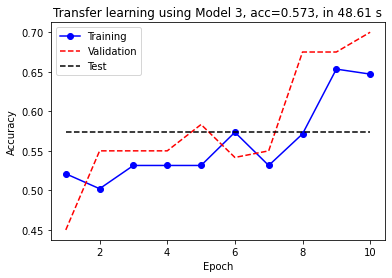

In [27]:
plot_result(historyC,results_test)   
plt.title("Transfer learning using Model 3, acc=%2.3f, in %3.2f s"%(results_test[1],total_time)) #overwrite the title
plt.show

In [28]:
tf.random.set_seed(0)                             # set our initial seed

modelD = tf.keras.models.Sequential([             # model type
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),                    # Dropout helps reduce overfitting 
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
#===
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, name='SGD')
adm = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
modelD.compile(optimizer=adm,
              loss='categorical_crossentropy',    #need to define our loss function
              metrics=['accuracy'])
#===
tstart   = tf.timestamp()
historyD = modelD.fit(X_train, Y_train, verbose=1,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split = 0.2) 
total_time = tf.timestamp() - tstart
print("total time %3.3f seconds"%total_time)

Epoch 1/10
3/3 [==============================] - 6s 2s/step - loss: 1.6825 - accuracy: 0.5147 - val_loss: 1.5418 - val_accuracy: 0.5500
Epoch 2/10
3/3 [==============================] - 5s 1s/step - loss: 1.1131 - accuracy: 0.5357 - val_loss: 0.6938 - val_accuracy: 0.4500
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 0.6925 - accuracy: 0.4769 - val_loss: 0.6925 - val_accuracy: 0.5083
Epoch 4/10
3/3 [==============================] - 4s 1s/step - loss: 0.6905 - accuracy: 0.5273 - val_loss: 0.6762 - val_accuracy: 0.5500
Epoch 5/10
3/3 [==============================] - 5s 2s/step - loss: 0.6807 - accuracy: 0.5336 - val_loss: 0.6505 - val_accuracy: 0.5917
Epoch 6/10
3/3 [==============================] - 5s 1s/step - loss: 0.6570 - accuracy: 0.6008 - val_loss: 0.6321 - val_accuracy: 0.5583
Epoch 7/10
3/3 [==============================] - 5s 2s/step - loss: 0.6456 - accuracy: 0.5924 - val_loss: 0.5703 - val_accuracy: 0.7167
Epoch 8/10
3/3 [=========================

In [29]:
modelD.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 28800)             0         
                                                                 
 dropout_3 (Dropout)         (None, 28800)            

In [30]:
results_test = modelD.evaluate(X_test, Y_test, batch_size=200, verbose=0)    
printAccuracy(historyD,results_test)

train loss 0.50452 	 train acc: 0.77101
valid loss 0.50020 	 valid acc: 0.73333
test loss  0.61837 	 test acc:  0.69333


<function matplotlib.pyplot.show(close=None, block=None)>

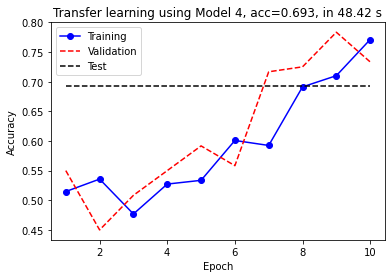

In [31]:
plot_result(historyD,results_test)   
plt.title("Transfer learning using Model 4, acc=%2.3f, in %3.2f s"%(results_test[1],total_time)) #overwrite the title
plt.show

## Drop out

In [32]:
dropouts      = [0,0.1,0.2,0.4,0.5,0.6,0.8]
hiddenNeurons = 50
epochs        = 10
batch_size    = 200

In [33]:
def runNNModel_DropOut(D):
    tf.random.set_seed(0)                             # set our initial seed
    modelD = tf.keras.models.Sequential([             # model type
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(D),                    # Dropout helps reduce overfitting 
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(D),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
    sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False, name='SGD')
    adm = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
    modelD.compile(optimizer=adm,
                  loss='categorical_crossentropy',    #need to define our loss function
                  metrics=['accuracy'])
    history = modelD.fit(X_train, Y_train, verbose=0,
                        epochs=epochs,
                        batch_size= batch_size,                 #change for each run
                        validation_split = 0.2) 
    return history.history['val_accuracy'] 

In [34]:
valAccuracy = []   
for D in dropouts:
    print("Starting drop outs %2.2f"%D,end=' ');
    tstart = tf.timestamp()
    valAcc_D = runNNModel_DropOut(D)
    valAccuracy.append(valAcc_D)
    total_time = tf.timestamp() - tstart
    print("total time %3.3f seconds"%total_time)

Starting drop outs 0.00 total time 51.780 seconds
Starting drop outs 0.10 total time 53.039 seconds
Starting drop outs 0.20 total time 50.154 seconds
Starting drop outs 0.40 total time 51.907 seconds
Starting drop outs 0.50 total time 50.509 seconds
Starting drop outs 0.60 total time 50.054 seconds
Starting drop outs 0.80 total time 52.805 seconds


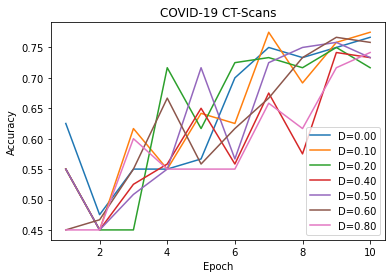

In [35]:
fig = plt.figure()
for v,D in zip(valAccuracy, dropouts):   
    epoch_count = range(1, len(v) + 1)               # Create count of the number of epochs
    plt.plot(epoch_count, v,label='D=%2.2f'%D)
#===========    
plt.legend()
plt.title("COVID-19 CT-Scans")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## activation function

In [36]:
activations   = ['sigmoid','tanh','relu','elu']
hiddenNeurons = 50
epochs        = 10
batch_size    = 200

In [37]:
def runNNModel_ActivationFunctions(A):
    tf.random.set_seed(0)                             # set our initial seed
    modelA = tf.keras.models.Sequential([             # model type
    tf.keras.layers.Conv2D(32, (3, 3), activation=A,  
                           padding='valid', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Conv2D(32, (3, 3), activation=A,  
                           padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(D),                    # Dropout helps reduce overfitting 
    tf.keras.layers.Dense(100, activation=A),
    tf.keras.layers.Dense(100, activation=A),
    tf.keras.layers.Dense(2, activation='softmax')
])
    sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False, name='SGD')
    adm = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
    modelA.compile(optimizer=adm,
                  loss='categorical_crossentropy',    #need to define our loss function
                  metrics=['accuracy'])
    history = modelA.fit(X_train, Y_train, verbose=0,
                        epochs=epochs,
                        batch_size= batch_size,                 #change for each run
                        validation_split = 0.2) 
    return history.history['val_accuracy'] 

In [38]:
valAccuracy = []   
for A in activations:
    print("Starting batchsize %s"%A,end=' ');
    tstart = tf.timestamp()
    valAcc_A = runNNModel_ActivationFunctions(A)
    valAccuracy.append(valAcc_A)
    total_time = tf.timestamp() - tstart
    print("total time %3.3f seconds"%total_time)

Starting batchsize sigmoid total time 57.274 seconds
Starting batchsize tanh total time 56.033 seconds
Starting batchsize relu total time 52.514 seconds
Starting batchsize elu total time 66.412 seconds


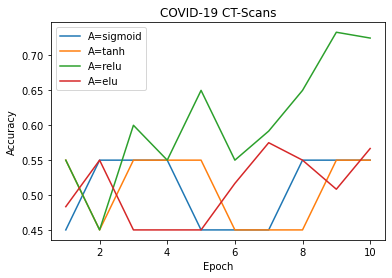

In [39]:
fig = plt.figure()
for v,A in zip(valAccuracy, activations):   
    epoch_count = range(1, len(v) + 1)               # Create count of the number of epochs
    plt.plot(epoch_count, v,label='A=%s'%A)
#===========    
plt.legend()
plt.title("COVID-19 CT-Scans")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## build final model

In [40]:
epochs = 20
batch_size = 100

In [41]:
tf.random.set_seed(0)                             # set our initial seed

modelD = tf.keras.models.Sequential([             # model type
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
#                            padding='valid'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),                    # Dropout helps reduce overfitting 
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
#===
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, name='SGD')
adm = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
modelD.compile(optimizer=adm,
              loss='categorical_crossentropy',    #need to define our loss function
              metrics=['accuracy'])
#===
tstart   = tf.timestamp()
historyD = modelD.fit(X_train, Y_train, verbose=1,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split = 0.2) 
total_time = tf.timestamp() - tstart
print("total time %3.3f seconds"%total_time)

Epoch 1/20
5/5 [==============================] - 5s 796ms/step - loss: 6.5443 - accuracy: 0.5084 - val_loss: 4.3373 - val_accuracy: 0.4500
Epoch 2/20
5/5 [==============================] - 4s 737ms/step - loss: 2.3520 - accuracy: 0.5210 - val_loss: 1.4140 - val_accuracy: 0.4500
Epoch 3/20
5/5 [==============================] - 4s 740ms/step - loss: 1.6460 - accuracy: 0.4832 - val_loss: 0.8157 - val_accuracy: 0.5500
Epoch 4/20
5/5 [==============================] - 3s 692ms/step - loss: 0.9566 - accuracy: 0.5315 - val_loss: 0.7082 - val_accuracy: 0.5500
Epoch 5/20
5/5 [==============================] - 3s 690ms/step - loss: 0.6839 - accuracy: 0.5966 - val_loss: 0.6789 - val_accuracy: 0.5083
Epoch 6/20
5/5 [==============================] - 4s 773ms/step - loss: 0.6414 - accuracy: 0.6029 - val_loss: 0.5940 - val_accuracy: 0.6917
Epoch 7/20
5/5 [==============================] - 4s 904ms/step - loss: 0.5853 - accuracy: 0.7059 - val_loss: 0.5536 - val_accuracy: 0.6833
Epoch 8/20
5/5 [====

In [42]:
modelD.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 127008)            0         
                                                                 
 dropout_22 (Dropout)        (None, 127008)            0         
                                                                 
 dense_46 (Dense)            (None, 100)               12700900  
                                                                 
 dense_47 (Dense)            (None, 100)               10100     
                                                     

In [43]:
results_test = modelD.evaluate(X_test, Y_test, batch_size=200, verbose=0)    
printAccuracy(historyD,results_test)

train loss 0.00266 	 train acc: 1.00000
valid loss 1.15191 	 valid acc: 0.75000
test loss  1.39978 	 test acc:  0.73333


<function matplotlib.pyplot.show(close=None, block=None)>

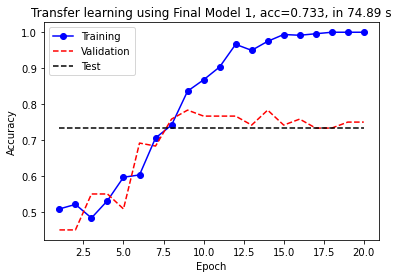

In [44]:
plot_result(historyD,results_test)   
plt.title("Transfer learning using Final Model 1, acc=%2.3f, in %3.2f s"%(results_test[1],total_time)) #overwrite the title
plt.show

In [45]:
epochs = 12
batch_size = 100

In [46]:
tf.random.set_seed(0)                             # set our initial seed

modelD = tf.keras.models.Sequential([             # model type
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
                           padding='valid', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  
#                            padding='valid'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),                    # Dropout helps reduce overfitting 
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
#===
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, name='SGD')
adm = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
modelD.compile(optimizer=adm,
              loss='categorical_crossentropy',    #need to define our loss function
              metrics=['accuracy'])
#===
tstart   = tf.timestamp()
historyD = modelD.fit(X_train, Y_train, verbose=1,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split = 0.2) 
total_time = tf.timestamp() - tstart
print("total time %3.3f seconds"%total_time)

Epoch 1/12
5/5 [==============================] - 4s 789ms/step - loss: 6.0111 - accuracy: 0.5042 - val_loss: 6.1118 - val_accuracy: 0.5500
Epoch 2/12
5/5 [==============================] - 3s 699ms/step - loss: 3.8628 - accuracy: 0.4979 - val_loss: 1.6493 - val_accuracy: 0.4500
Epoch 3/12
5/5 [==============================] - 4s 729ms/step - loss: 1.1091 - accuracy: 0.5441 - val_loss: 1.1108 - val_accuracy: 0.5500
Epoch 4/12
5/5 [==============================] - 4s 740ms/step - loss: 0.8756 - accuracy: 0.5231 - val_loss: 0.6790 - val_accuracy: 0.5250
Epoch 5/12
5/5 [==============================] - 3s 696ms/step - loss: 0.6825 - accuracy: 0.5189 - val_loss: 0.6359 - val_accuracy: 0.5750
Epoch 6/12
5/5 [==============================] - 3s 687ms/step - loss: 0.6251 - accuracy: 0.6176 - val_loss: 0.5944 - val_accuracy: 0.6500
Epoch 7/12
5/5 [==============================] - 3s 679ms/step - loss: 0.6003 - accuracy: 0.6702 - val_loss: 0.5426 - val_accuracy: 0.7667
Epoch 8/12
5/5 [====

In [47]:
modelD.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 127008)            0         
                                                                 
 dropout_23 (Dropout)        (None, 127008)            0         
                                                                 
 dense_50 (Dense)            (None, 100)               12700900  
                                                                 
 dense_51 (Dense)            (None, 100)               10100     
                                                     

In [48]:
results_test = modelD.evaluate(X_test, Y_test, batch_size=200, verbose=0)    
printAccuracy(historyD,results_test)

train loss 0.13213 	 train acc: 0.96429
valid loss 0.66991 	 valid acc: 0.74167
test loss  0.68762 	 test acc:  0.74000


<function matplotlib.pyplot.show(close=None, block=None)>

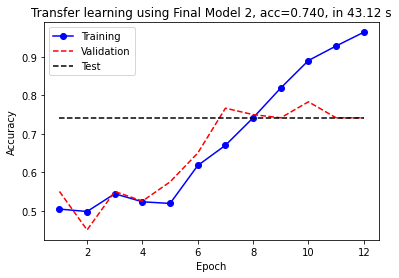

In [49]:
plot_result(historyD,results_test)   
plt.title("Transfer learning using Final Model 2, acc=%2.3f, in %3.2f s"%(results_test[1],total_time)) #overwrite the title
plt.show

In [50]:
# same number of epoch, optimizers, train different NN structure
# different optimizer (Adam , sgd)
# X scaling
# learning rate